In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [61]:
path = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(path)
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [62]:
# Étape 1 — Sélection des colonnes, conversion date, mise en index
df["Month"] = pd.to_datetime(df["Month"])
ts = df.set_index("Month")["Passengers"].asfreq("MS")  # MS = month start
ts.name = "passagers"

print("Shape:", ts.shape)
print("Période:", ts.index.min().date(), "->", ts.index.max().date())
ts.head()


Shape: (144,)
Période: 1949-01-01 -> 1960-12-01


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Freq: MS, Name: passagers, dtype: int64

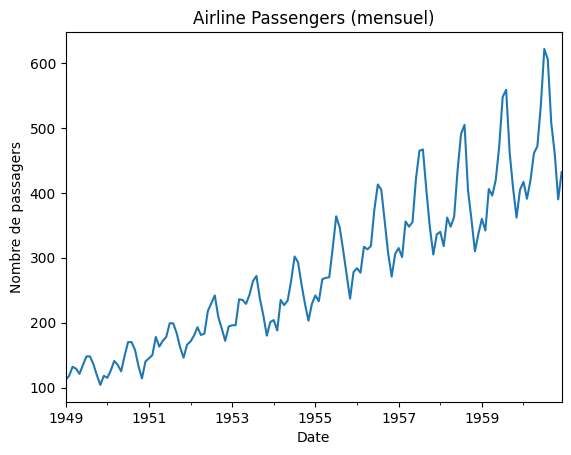

In [63]:
# Étape 2 — Visualisation de la série
plt.figure()
ts.plot()
plt.title("Airline Passengers (mensuel)")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.show()



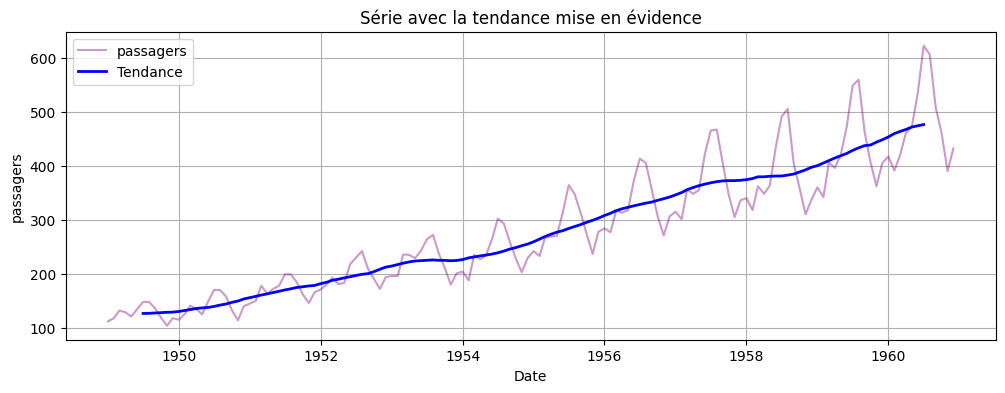

In [64]:
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, color='purple', alpha=0.4, label='passagers')
trend = ts.rolling(window=12, center=True).mean()
plt.plot(trend.index, trend.values, color='blue', linewidth=2, label='Tendance')
plt.title("Série avec la tendance mise en évidence")
plt.xlabel("Date")
plt.ylabel("passagers")
plt.grid(True)
plt.legend()
plt.show()

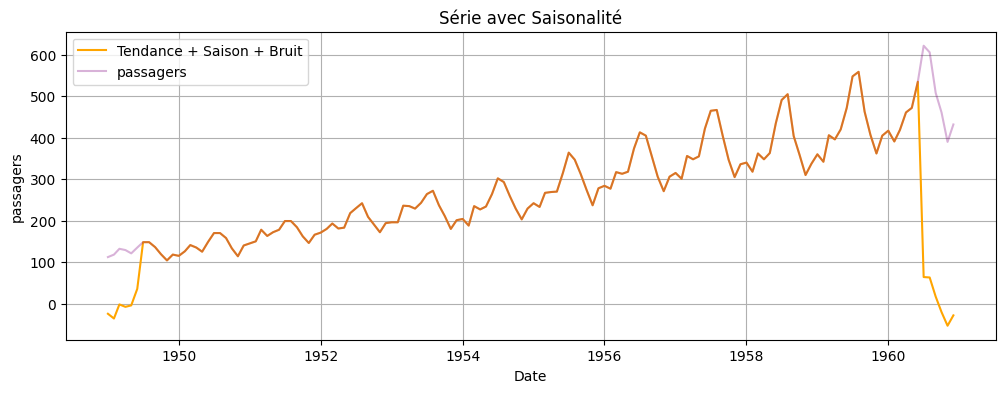

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(12,4))
decomp = seasonal_decompose(ts, model='additive', period=12)
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

plt.plot(ts.index, (trend.fillna(0) + seasonal.fillna(0) + resid.fillna(0)), color='orange', label='Tendance + Saison + Bruit')
plt.plot(ts.index, ts.values, color='purple', alpha=0.3, label='passagers')
plt.title("Série avec Saisonalité")
plt.xlabel("Date")
plt.ylabel("passagers")
plt.grid(True)
plt.legend()
plt.show()

In [66]:
# Étape 3 — Test ADF (stationnarité)
def adf_report(series, name=""):
    s = series.dropna()
    stat, pval, lags, nobs, *_ = adfuller(s, autolag="AIC")
    return {"serie": name, "ADF_stat": stat, "p_value": pval, "lags": lags, "nobs": nobs}

adf_raw = adf_report(ts, "Original")
pd.DataFrame([adf_raw])



,serie,ADF_stat,p_value,lags,nobs
0,Original,0.815369,0.99188,13,130


notre serie n'est pas stationnaire donc nous allons appliquer des tests de logarithme ou différenciation pour la rendre stationnaire

In [67]:
# Étape 4 — Transformations pour stationnarité
# 4.1 log pour stabiliser la variance
ts_log = np.log(ts)
adf_log = adf_report(ts_log, "Log(ts)")

# 4.2 Différenciation (1er ordre) sur log
ts_log_diff = ts_log.diff()
adf_log_diff = adf_report(ts_log_diff, "Diff(Log(ts))")

# 4.3 Diff saisonnière (période 12) sur log diff si besoin
ts_log_diff_seas = ts_log_diff.diff(12)
adf_log_diff_seas = adf_report(ts_log_diff_seas, "Diff12(Diff(Log(ts)))")

pd.DataFrame([adf_raw, adf_log, adf_log_diff, adf_log_diff_seas])



,serie,ADF_stat,p_value,lags,nobs
0,Original,0.815369,0.991880,13,130
1,Log(ts),-1.717017,0.422367,13,130
2,Diff(Log(ts)),-2.717131,0.071121,14,128
3,Diff12(Diff(Log(ts))),-4.443325,0.000249,12,118


apres trois transformation notre serie est maintenant stationnaire.

<Figure size 640x480 with 0 Axes>

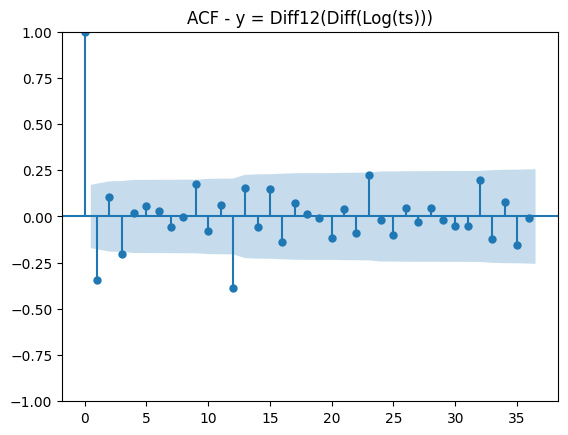

<Figure size 640x480 with 0 Axes>

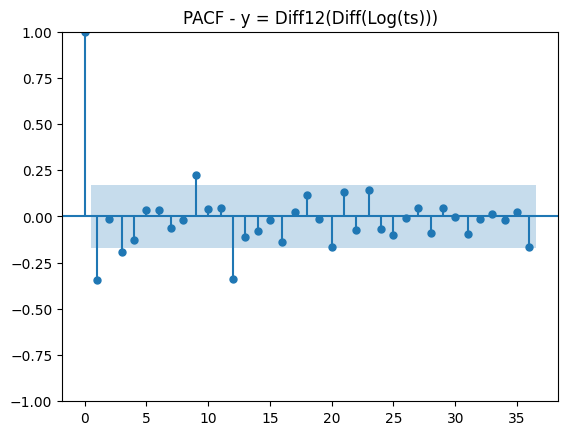

In [68]:
# On choisit la série stationnaire finale :
# y = Diff12(Diff(Log(ts)))  -> stationnaire (p-value < 0.05)
y = ts_log_diff_seas

# Étape 5 — ACF/PACF pour estimer p et q
plt.figure()
plot_acf(y.dropna(), lags=36)
plt.title("ACF - y = Diff12(Diff(Log(ts)))")
plt.show()

plt.figure()
plot_pacf(y.dropna(), lags=36, method="ywm")
plt.title("PACF - y = Diff12(Diff(Log(ts)))")
plt.show()



In [69]:
test_h = 12
y_train = y.iloc[:-test_h]
y_test  = y.iloc[-test_h:]

print("Train:", y_train.index.min(), "->", y_train.index.max(), "|", len(y_train))
print("Test :", y_test.index.min(),  "->", y_test.index.max(),  "|", len(y_test))


Train: 1949-01-01 00:00:00 -> 1959-12-01 00:00:00 | 132
Test : 1960-01-01 00:00:00 -> 1960-12-01 00:00:00 | 12


In [70]:
# Étape 7 — Ajuster un modèle ARMA(p,q) sur y_train
# On fait un mini grid-search rapide via AIC sur p,q <= 3
def arma_grid_aic(series, p_max=3, q_max=3):
    best_aic = np.inf
    best_order = None
    best_model = None
    rows = []
    for p in range(p_max + 1):
        for q in range(q_max + 1):
            if p == 0 and q == 0:
                continue
            try:
                m = ARIMA(series, order=(p,0,q), trend="n").fit()
                rows.append((p, q, m.aic))
                if m.aic < best_aic:
                    best_aic = m.aic
                    best_order = (p,0,q)
                    best_model = m
            except Exception:
                rows.append((p, q, np.nan))
    table = pd.DataFrame(rows, columns=["p", "q", "AIC"]).sort_values("AIC")
    return best_order, best_aic, best_model, table

best_order, best_aic, best_model, aic_table = arma_grid_aic(y_train, 3, 3)
p, d, q = best_order
print("Meilleur ARMA (AIC):", f"ARMA({p},{q})  | AIC =", best_aic)
aic_table.head(10)



Meilleur ARMA (AIC): ARMA(3,2)  | AIC = -415.9783543614114


,p,q,AIC
13,3,2,-415.978354
10,2,3,-414.480497
14,3,3,-412.847465
8,2,1,-411.158312
2,0,3,-410.606073
11,3,0,-410.290296
0,0,1,-409.852783
3,1,0,-409.621802
12,3,1,-409.008333
6,1,3,-408.819932


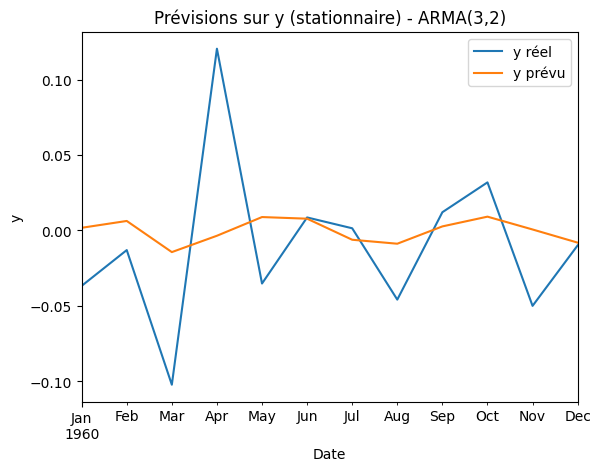

In [71]:
fc_y = best_model.forecast(steps=len(y_test))
fc_y = pd.Series(fc_y.values, index=y_test.index, name="y_pred")

plt.figure()
y_test.plot(label="y réel")
fc_y.plot(label="y prévu")
plt.title(f"Prévisions sur y (stationnaire) - ARMA({p},{q})")
plt.xlabel("Date")
plt.ylabel("y")
plt.legend()
plt.show()


In [72]:
rmse = np.sqrt(mean_squared_error(y_test, fc_y))
mape = mean_absolute_percentage_error(y_test, fc_y)

print("RMSE (sur y):", rmse)
print("MAPE (sur y):", mape)


RMSE (sur y): 0.05126265116205098
MAPE (sur y): 1.2317528711203225


In [73]:

# Afficher un résumé du modèle
print(best_model.summary())



                               SARIMAX Results                                
Dep. Variable:              passagers   No. Observations:                  132
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 213.989
Date:                Tue, 13 Jan 2026   AIC                           -415.978
Time:                        09:24:21   BIC                           -398.682
Sample:                    01-01-1949   HQIC                          -408.950
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1324      0.084     -1.567      0.117      -0.298       0.033
ar.L2         -0.7639      0.077     -9.965      0.000      -0.914      -0.614
ar.L3         -0.4279      0.070     -6.099      0.0

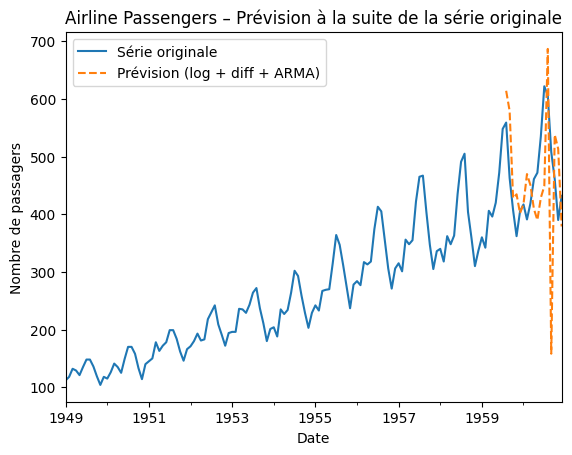

In [75]:
# Use the model we selected earlier: ARMA(3,2)
model = ARIMA(y_train, order=(3,0,2), trend="n").fit()

# Forecast on transformed scale
fc_y = model.forecast(steps=h)

# ===== Reconstruct predictions back to original scale =====
# We reconstruct log(ts) step by step
log_ts = ts_log.copy()

reconstructed_log = []
last_log = log_ts.iloc[-h-1]
for i in range(h):
    # inverse seasonal + first difference
    value = fc_y.iloc[i] + log_ts.iloc[-h-1+i] + (log_ts.iloc[-13+i] - log_ts.iloc[-14+i])
    reconstructed_log.append(value)

reconstructed_log = pd.Series(reconstructed_log, index=ts.index[-h:])

# Back to original scale
pred_passengers = np.exp(reconstructed_log)

# ===== Plot original + prediction =====
plt.figure()
ts.plot(label="Série originale")
pred_passengers.plot(label="Prévision (log + diff + ARMA)", linestyle="--")
plt.title("Airline Passengers – Prévision à la suite de la série originale")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.show()